# 라이브러리 및 데이터 로드

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels as sm
import seaborn as sns

C:\Users\sinra\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sinra\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\sinra\anaconda3\lib\site-packages\numpy\.libs\libopenblas.fb5ae2tyxyh2ijrdkgdgq3xbklktf43h.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
sales_data =  pd.read_csv('sales_data.csv', encoding='unicode_escape')

# EDA

In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


* Description은 null이 있지만 주석 처리 데이터이므로 중요하지 않은 것 같다.
* CustomerID가 null인 경우는 비로그인이지 않을까? -> 로그인 / 비로그인 유저 나눠봐야 할지
* Invoice'No'라서 숫자형일줄 알았는데 object형임.

In [4]:
sales_data['InvoiceNo'].sort_values()
# 문자열이 섞여 있다.

0          536365
1          536365
2          536365
3          536365
4          536365
           ...   
540449    C581490
541541    C581499
541715    C581568
541716    C581569
541717    C581569
Name: InvoiceNo, Length: 541909, dtype: object

## 데이터 형변환

In [6]:
# 데이터 형변환 필요해보인다. customerID가 float인 거 불편..
sales_data['CustomerID'] = sales_data['CustomerID'].fillna(-1)
sales_data['CustomerID'] = sales_data['CustomerID'].astype('int64')

In [7]:
# 구매날짜도 datetime으로 형 변환. 
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
sales_data['InvoiceDate_only'] = sales_data['InvoiceDate'].dt.normalize()

In [11]:
# 총 구매액 변수 생성
sales_data['TotalPrice'] = sales_data['UnitPrice']*sales_data['Quantity']

## 변수별 특성 확인

In [8]:
# 국가별 분포 확인 -> 한 쪽에 몰려 있어 특성을 나눠보는 것은 고려하지 않음.
sales_data.groupby(['Country'])['InvoiceNo'].agg('count').sort_values(ascending = False)[:10]

Country
United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: InvoiceNo, dtype: int64

### InvoiceNo 확인
- 앞에 C가 붙으면 환불인 것 같다. -> Quantity가 음수로 나옴
- 환불이 진행되더라도, InvoiceNo가 유사하게 나타나지는 않음.

In [10]:
sales_data[sales_data['InvoiceNo'].str.startswith('C')].query("Quantity > 0")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only


In [12]:
sales_data[sales_data['InvoiceNo'].str.endswith('545569')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only
108915,C545569,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-2,2011-03-03 16:25:00,4.95,14239,United Kingdom,2011-03-03
108916,C545569,22423,REGENCY CAKESTAND 3 TIER,-3,2011-03-03 16:26:00,12.75,14239,United Kingdom,2011-03-03
108917,C545569,22840,ROUND CAKE TIN VINTAGE RED,-1,2011-03-03 16:26:00,7.95,14239,United Kingdom,2011-03-03


In [13]:
sales_data.query('CustomerID==14239 and StockCode == "22720"')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only
107312,545428,22720,SET OF 3 CAKE TINS PANTRY DESIGN,3,2011-03-02 14:43:00,4.95,14239,United Kingdom,2011-03-02
108915,C545569,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-2,2011-03-03 16:25:00,4.95,14239,United Kingdom,2011-03-03


### StockCode 확인
* 상품 코드, 총 4070 종류

In [14]:
sales_data.groupby(['StockCode'])['InvoiceNo'].nunique().sort_values(ascending = False)

StockCode
85123A    2246
22423     2172
85099B    2135
47566     1706
20725     1608
          ... 
20678        1
23652        1
20689        1
85226C       1
m            1
Name: InvoiceNo, Length: 4070, dtype: int64

### 상품 금액대별 분포 확인
* 환불이 아닌 경우라도 UnitPrice가 음수인 경우가 있음 -> 이 경우 StockCode == 'B' (Adjust Bad Debt), 빚인 듯 하다.
* 금액대가 제법 큰 경우는 운송비(AMAZONFEE, POST)거나, 맞춤제작(M)인 경우로 보임.

In [18]:
# 금액이 음수인 경우가 있음.
sales_data.query('Quantity > 0').sort_values(by = 'UnitPrice', ascending = False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only,TotalPrice
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,-1,United Kingdom,2010-12-07,13541.33
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,-1,United Kingdom,2011-08-12,11062.06
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,2011-05-03,8142.75
297723,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,-1,United Kingdom,2011-08-11,4505.17
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,-1,United Kingdom,2011-07-18,4287.63
...,...,...,...,...,...,...,...,...,...,...
258274,559603,79337,NaN,1,2011-07-11 11:27:00,0.00,-1,United Kingdom,2011-07-11,0.00
258273,559602,84686,NaN,23,2011-07-11 11:26:00,0.00,-1,United Kingdom,2011-07-11,0.00
21777,538128,21357,NaN,46,2010-12-09 15:54:00,0.00,-1,United Kingdom,2010-12-09,0.00
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,-1,United Kingdom,2011-08-12,-11062.06


In [ ]:
# sales_data.query("Quantity > 0 and StockCode != 'B' and InvoiceNo not in ('537632', '551697', '562955') and UnitPrice > 0").\
# sort_values(by = 'UnitPrice', ascending = False).head(50)

In [12]:
# 위에서 언급한 변수들(빚, 운송비, 맞춤제작 상품) 제거하면 금액대가 600달러(?) 수준으로 들어옴.
sales_data.query("StockCode not in ('B', 'AMAZONFEE', 'DOT', 'POST', 'M') and Quantity > 0").\
    sort_values(by = 'UnitPrice', ascending = False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_only,TotalPrice
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom,2011-06-10,649.5
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom,2011-06-10,38970.0
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607,United Kingdom,2010-12-16,295.0
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015,United Kingdom,2011-05-26,295.0
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.0,14973,United Kingdom,2011-04-28,295.0
...,...,...,...,...,...,...,...,...,...,...
51761,540677,21667,NaN,1,2011-01-10 16:20:00,0.0,-1,United Kingdom,2011-01-10,0.0
242424,558340,22627,MINT KITCHEN SCALES,1,2011-06-28 14:01:00,0.0,-1,United Kingdom,2011-06-28,0.0
417107,572614,23595,adjustment,5,2011-10-25 11:38:00,0.0,-1,United Kingdom,2011-10-25,0.0
51760,540676,84534B,NaN,12,2011-01-10 16:05:00,0.0,-1,United Kingdom,2011-01-10,0.0


<Axes: xlabel='InvoiceDate_only'>

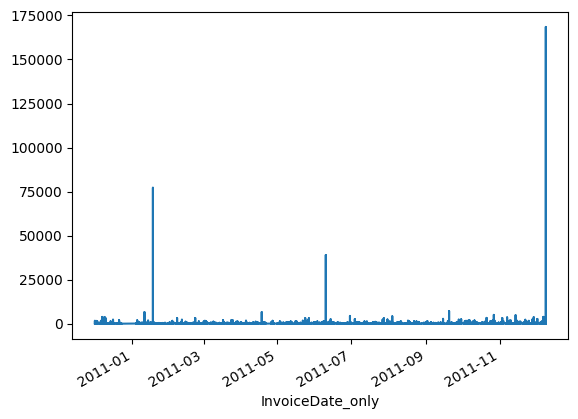

In [16]:
sales_data.query("StockCode not in ('B', 'AMAZONFEE', 'DOT', 'POST', 'M') and Quantity > 0").\
    set_index('InvoiceDate_only')['TotalPrice'].plot()

<Axes: >

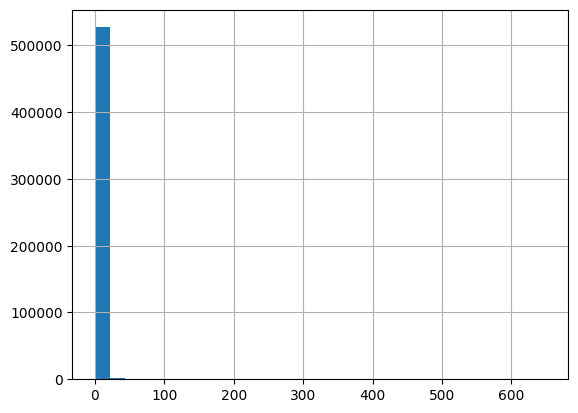

In [14]:
# 상품 금액대별 분포
sales_data.query("StockCode not in ('B', 'AMAZONFEE', 'DOT', 'POST', 'M') and Quantity > 0")['UnitPrice'].hist(bins = 30)

<Axes: >

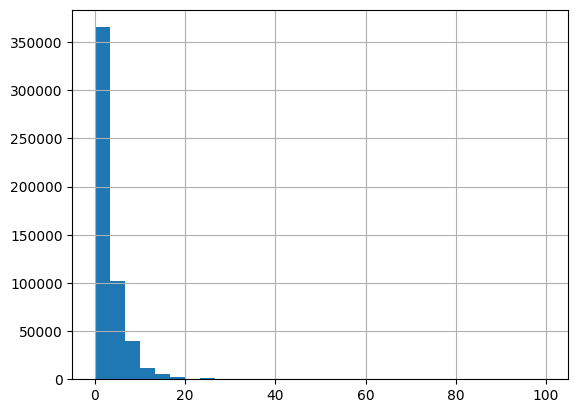

In [15]:
sales_data.query("StockCode not in ('B', 'AMAZONFEE', 'DOT', 'POST', 'M') and Quantity > 0 and UnitPrice < 100")\
    ['UnitPrice'].hist(bins = 30)

In [22]:
# 상품 금액대 별로 나눠서 보기
sales_data['Price_gubun'] = np.where(sales_data['UnitPrice'] < 100, 'under100', 'over100')

<Axes: xlabel='InvoiceDate_only', ylabel='TotalPrice'>

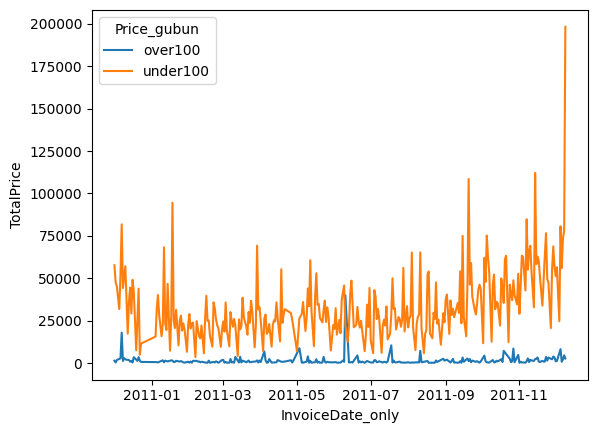

In [23]:
price_category = sales_data.query("Quantity > 0 and StockCode != 'B' and UnitPrice > 0").\
    groupby(['InvoiceDate_only', 'Price_gubun']).\
    agg({'TotalPrice' : 'sum'})
sns.lineplot(data = price_category, x = 'InvoiceDate_only', y = 'TotalPrice', hue = 'Price_gubun')

## 예측에 사용할 데이터 기준 정리
- 환불을 진행한 경우는 제외(그렇게 정한 건 예제 코드를 참고했기 때문....)
- 특정 상품코드(StockCode에서 B, M, POST 등)은 제외하고 분석 
  - 특정 날짜에 한 번씩 튀는데 그 외에는 거의 영향을 미친다고 보기 어려운 수준으로 판단함.
- 앞에서 만든 TotalPrice(UnitPrice*Quantity) 변수의 일별 합계를 예측 지표로 사용

In [17]:
# 분석의 확장성을 위해 일단 바로 일별로 aggregation을 하지는 않음.
sales_data_merge = sales_data.query("StockCode not in ('B', 'AMAZONFEE', 'DOT', 'POST', 'M') and Quantity > 0").\
    groupby(['InvoiceNo', 'Country', 'InvoiceDate_only', 'CustomerID']).\
    agg({'TotalPrice': 'sum','Quantity':'sum' }).reset_index()

# Train / Test Split

In [21]:
target_data = sales_data_merge.groupby('InvoiceDate_only')['TotalPrice'].agg('sum').reset_index()

In [42]:
target_data['WeekofDay'] = target_data['InvoiceDate_only'].dt.day_name()
target_data['Day'] = target_data['InvoiceDate_only'].dt.day
target_data['Month'] = target_data['InvoiceDate_only'].dt.month

<Axes: >

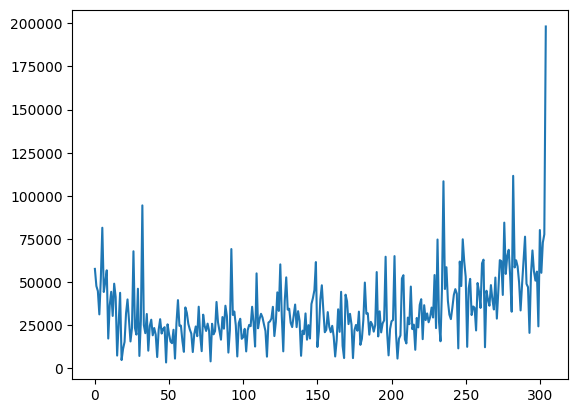

In [95]:
target_data['TotalPrice'].plot()

In [76]:
train_data = target_data.loc[:242, :]

In [77]:
train_data

,InvoiceDate_only,TotalPrice,WeekofDay,Day,Month
0,2010-12-01,57676.330,Wednesday,1,12
1,2010-12-02,47730.380,Thursday,2,12
2,2010-12-03,44833.980,Friday,3,12
3,2010-12-05,31318.990,Sunday,5,12
4,2010-12-06,51973.430,Monday,6,12
...,...,...,...,...,...
238,2011-09-23,39040.950,Friday,23,9
239,2011-09-25,31174.661,Sunday,25,9
240,2011-09-26,28581.091,Monday,26,9
241,2011-09-27,35169.140,Tuesday,27,9


In [78]:
test_data = target_data.loc[243:, :]

In [79]:
test_data

,InvoiceDate_only,TotalPrice,WeekofDay,Day,Month
243,2011-09-29,45945.84,Thursday,29,9
244,2011-09-30,43297.72,Friday,30,9
245,2011-10-02,11634.53,Sunday,2,10
246,2011-10-03,61919.16,Monday,3,10
247,2011-10-04,47755.79,Tuesday,4,10
...,...,...,...,...,...
300,2011-12-05,80182.35,Monday,5,12
301,2011-12-06,55411.69,Tuesday,6,12
302,2011-12-07,72937.70,Wednesday,7,12
303,2011-12-08,77694.64,Thursday,8,12


# ARIMA
* 조건 : 정상성을 만족해야 함 -> 만일 정상성을 만족하지 못한다면 차분을 진행해야 함. (ADF test 사용 가능)
* 적절한 모형을 찾기 위해 ACF, PACF 플롯을 그려볼 수 있음.
* 하지만 auto_arima를 쓸 수도 있음.
* 외생변수(exog)를 parameter로 넣을 수도 있음. 

In [80]:
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pmdarima import auto_arima 
from statsmodels.tsa.stattools import adfuller

<Axes: >

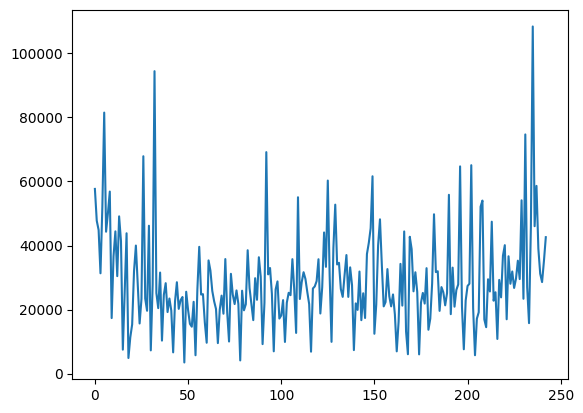

In [81]:
train_data['TotalPrice'].plot()

<Axes: >

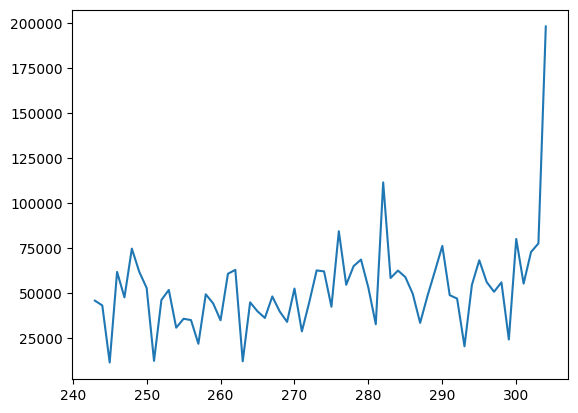

In [82]:
test_data['TotalPrice'].plot()

##  ACF / PACF 그려보기
* 초반에 lag6마다 튀는 것 같음. 그런데 시간이 지나면서 희석됨.
* 그림만 보면 계절성 차분은 필요할 수도 있고, 아닌 것 같기도 함..

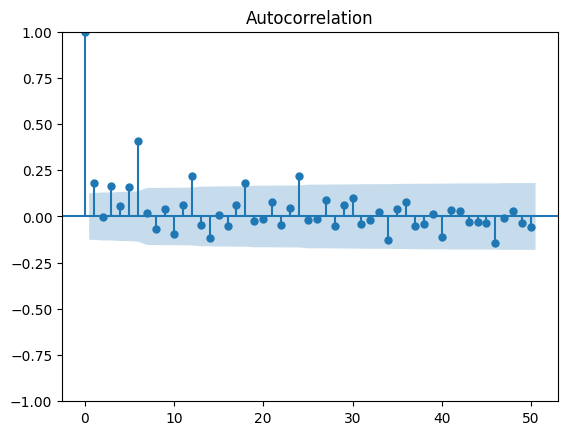

In [96]:
plot_acf(train_data['TotalPrice'], lags = 50)
plt.show()

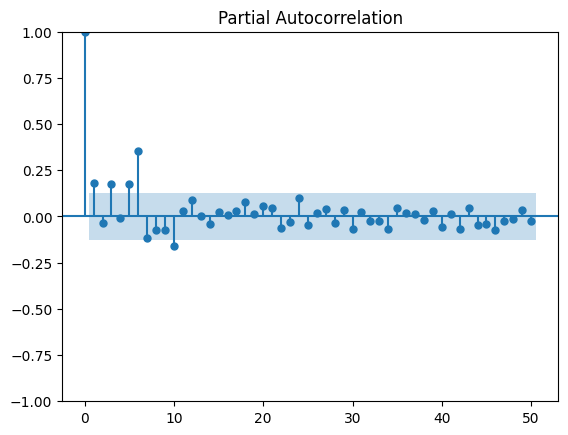

In [97]:
plot_pacf(train_data['TotalPrice'], lags = 50)
plt.show()

## ADF 테스트 진행 (정상성 검정)

In [98]:
adf_result = adfuller(train_data['TotalPrice'])

## return
# Returns
# -------
# adf : float
#     The test statistic.
# pvalue : float
#     MacKinnon's approximate p-value based on MacKinnon (1994, 2010).
# usedlag : int
#     The number of lags used.
# nobs : int
#     The number of observations used for the ADF regression and calculation
#     of the critical values.
# critical values : dict
#     Critical values for the test statistic at the 1 %, 5 %, and 10 %
#     levels. Based on MacKinnon (2010).
# icbest : float
#     The maximized information criterion if autolag is not None.
# resstore : ResultStore, optional
#     A dummy class with results attached as attributes.

In [99]:
adf_result

(-4.802844124093778,
 5.370868568172705e-05,
 9,
 233,
 {'1%': -3.458731141928624,
  '5%': -2.8740258764297293,
  '10%': -2.5734243167124093},
 4958.657743467135)

* 결과 해석 : p_value가 0.05보다 작다 => 정상성을 만족한다고 봐도 될 듯.

## auto.arima

In [109]:
auto_arima(train_data['TotalPrice'], trace = True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5369.403, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5372.289, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5366.239, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5365.583, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5741.928, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5368.366, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5367.352, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5370.730, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5629.171, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.977 seconds


ARIMA(order=(0, 0, 1), scoring_args={}, suppress_warnings=True)

* ARIMA (0,0,1)을 추천 받음.

## ARIMA 1차 시도

In [88]:
arima_model = ARIMA(train_data['TotalPrice'], order = (0, 0, 1))

In [89]:
arima_results = arima_model.fit()
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             TotalPrice   No. Observations:                  243
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2679.640
Date:                Sat, 30 Mar 2024   AIC                           5365.280
Time:                        19:08:26   BIC                           5375.759
Sample:                             0   HQIC                          5369.501
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.884e+04   1196.549     24.102      0.000    2.65e+04    3.12e+04
ma.L1          0.2103      0.066      3.208      0.001       0.082       0.339
sigma2      2.206e+08      0.063   3.53e+09      0.000    2.21e+08    2.21e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               244.46
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             1.45
Prob(H) (two-sided):                  0.75   Kurtosis:                         6.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.67e+24. Standard errors may be unstable.
"""

In [101]:
arima_predictions = arima_results.predict(start=0, end=304, dynamic=False, typ='levels').\
    rename('ARIMA(0,0,1) Predictions')

C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


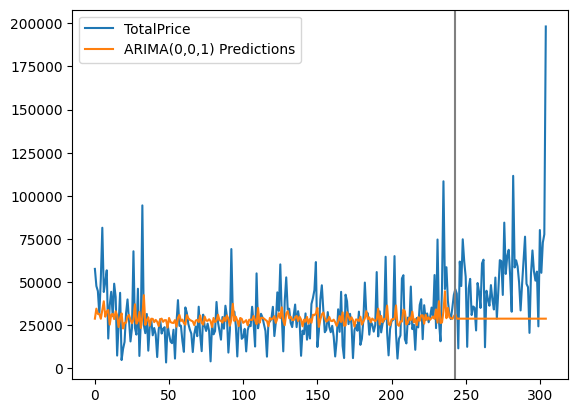

In [102]:
# 예측력 개똥망인듯.
target_data['TotalPrice'].plot(legend = True)
arima_predictions.plot(legend = True)
plt.axvline(x=243,color='grey', linestyle='solid')

## 외생변수 고려하여 ARIMA 2차 시도

In [103]:
arima_model_exog = ARIMA(train_data['TotalPrice'], order = (0, 0, 1), exog = train_data[['Day', 'Month']])

In [104]:
arima_exog_result = arima_model_exog.fit()

In [105]:
arima_exog_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             TotalPrice   No. Observations:                  243
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -2672.857
Date:                Sat, 30 Mar 2024   AIC                           5355.715
Time:                        19:13:23   BIC                           5373.180
Sample:                             0   HQIC                          5362.750
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.152e+04   3282.933      6.554      0.000    1.51e+04     2.8e+04
Day           -2.2601    143.167     -0.016      0.987    -282.863     278.343
Month       1310.8305    301.844      4.343      0.000     719.228    1902.433
ma.L1          0.1519      0.071      2.146      0.032       0.013       0.291
sigma2      2.104e+08      0.169   1.24e+09      0.000     2.1e+08     2.1e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               313.02
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             1.46
Prob(H) (two-sided):                  0.53   Kurtosis:                         7.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.65e+24. Standard errors may be unstable.
"""

In [110]:
arima_exog_predictions = arima_exog_result.predict(start=0, end=304, dynamic=False, typ='levels', 
                                                   exog = test_data[['Day', 'Month']]).\
    rename('ARIMA(0,0,1) exog Predictions')

C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


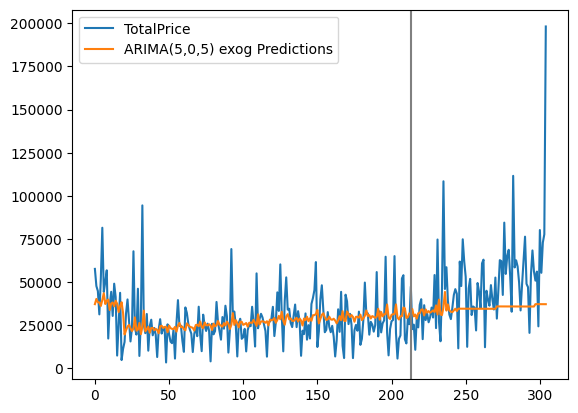

In [108]:
# 조금 나아지긴 했지만 여전히 예측지표 개똥망인듯.
target_data['TotalPrice'].plot(legend = True)
arima_exog_predictions.plot(legend = True)
plt.axvline(x=213, color='grey', linestyle='solid')

## ARIMA(5,0,5) 무지성으로 3차 시도

In [111]:
arima_model_exog_2 = ARIMA(train_data['TotalPrice'], order = (5, 0, 5), exog = train_data[['Day', 'Month']])

In [113]:
arima_exog_result2 = arima_model_exog_2.fit()

C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [114]:
arima_exog_predictions2 = arima_exog_result2.predict(start=0, end=304, dynamic=False, typ='levels', 
                                                   exog = test_data[['Day', 'Month']]).\
    rename('ARIMA(5,0,5) exog Predictions')

C:\Users\sinra\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


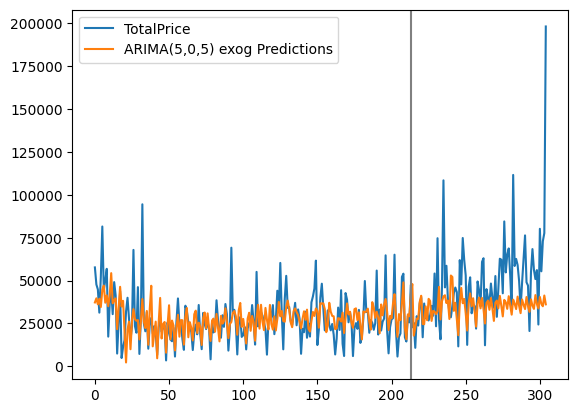

In [115]:
# 조금 나아지긴 했지만 여전히 예측지표 개똥망인듯.
target_data['TotalPrice'].plot(legend = True)
arima_exog_predictions2.plot(legend = True)
plt.axvline(x=213, color='grey', linestyle='solid')

## 잔차의 자기상관검정

In [116]:
resid = arima_exog_result.resid

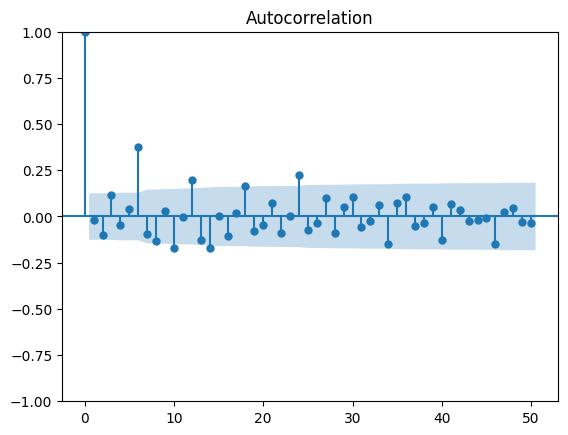

In [118]:
plot_acf(resid, lags = 50)
plt.show()

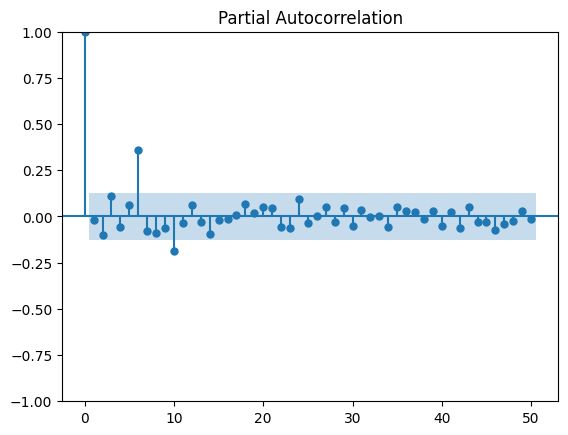

In [119]:
plot_pacf(resid, lags = 50)
plt.show()

In [120]:
from statsmodels.stats.stattools import durbin_watson

# Durbin-Watson 검정 수행
dw_test = durbin_watson(resid)

In [121]:
# 2에 가까우면 잔차의 자기상관은 없다고 봐야 함.
dw_test

2.0270284598413104

# Prophet 시도

In [122]:
from prophet import Prophet

In [132]:
train_data_prophet = train_data.rename(
    columns = {'InvoiceDate_only':'ds', 'TotalPrice':'y'}
).drop(['WeekofDay', 'Day', 'Month'], axis = 1)

In [134]:
train_data_prophet

,ds,y
0,2010-12-01,57676.330
1,2010-12-02,47730.380
2,2010-12-03,44833.980
3,2010-12-05,31318.990
4,2010-12-06,51973.430
...,...,...
238,2011-09-23,39040.950
239,2011-09-25,31174.661
240,2011-09-26,28581.091
241,2011-09-27,35169.140


In [135]:
Prophet_model = Prophet()

In [136]:
prophet_result = Prophet_model.fit(target_data_prophet)

19:24:45 - cmdstanpy - INFO - Chain [1] start processing
19:24:45 - cmdstanpy - INFO - Chain [1] done processing


In [142]:
future = prophet_result.make_future_dataframe(periods=62)
future.tail()

,ds
300,2011-11-25
301,2011-11-26
302,2011-11-27
303,2011-11-28
304,2011-11-29


In [143]:
forecast = prophet_result.predict(future)

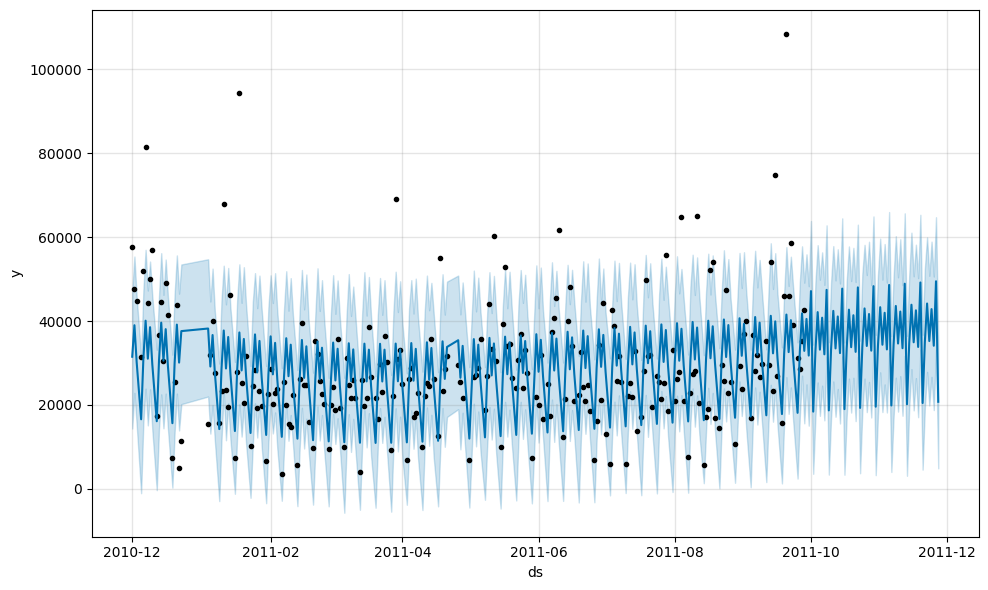

In [141]:
prophet_result.plot(forecast)
plt.show()

<Axes: >

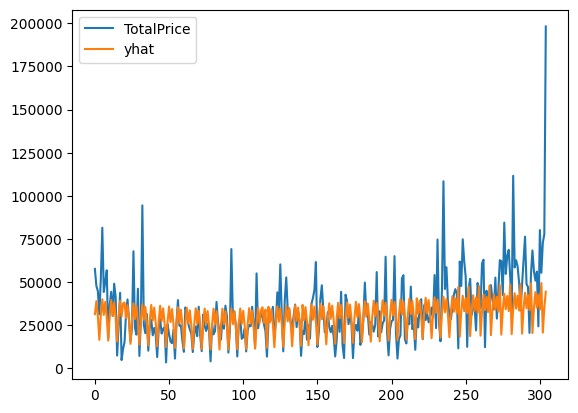

In [155]:
target_data['TotalPrice'].plot(legend = True)
forecast['yhat'].plot(legend = True)

C:\Users\sinra\anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


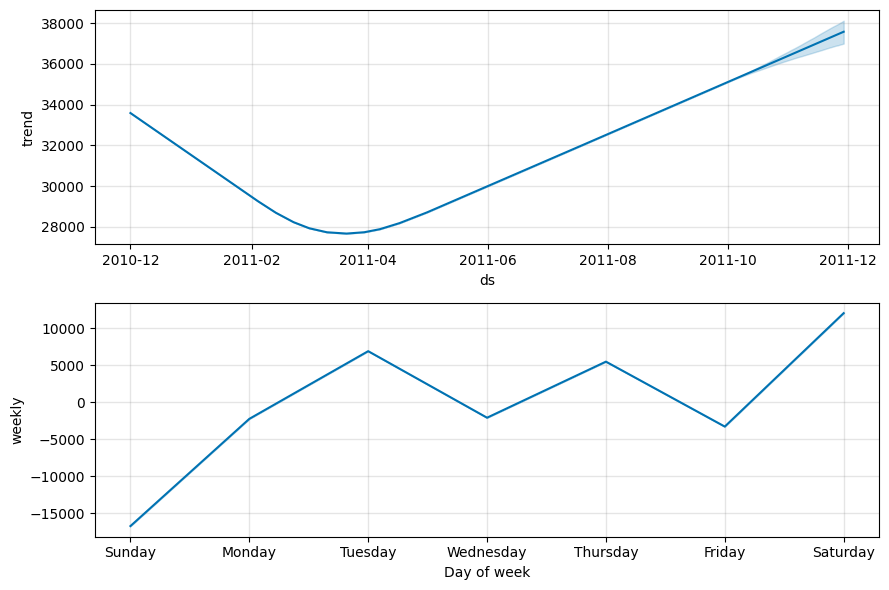

In [164]:
# from prophet.plot import plot_plotly, plot_components_plotly
Prophet_model.plot_components(forecast)
plt.show()

## 이하 정현님께서 공유주신 예제 샘플 참고

In [149]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [150]:


evaluation_model = cross_validation(Prophet_model, initial='232 days', period='62 days', horizon = '25 days')

  0%|          | 0/1 [00:00<?, ?it/s]

19:47:34 - cmdstanpy - INFO - Chain [1] start processing
19:47:34 - cmdstanpy - INFO - Chain [1] done processing


In [151]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,4.487321e+07,6698.747247,6244.502433,0.230945,0.230945,0.261118,1.0
1,3 days,6.848503e+07,8275.568238,8265.724168,0.258505,0.258505,0.257147,1.0
2,4 days,3.780722e+07,6148.757363,5788.535382,0.198447,0.198447,0.184816,1.0
3,5 days,4.134084e+07,6429.684446,6007.177567,0.213397,0.213397,0.196166,1.0
4,6 days,3.696031e+07,6079.499004,5272.150735,0.192989,0.192989,0.173643,1.0


# 분석에 대한 회고

* 기본적으로 도메인(?) 지식이 부족해서 분석 프로세스를 어설프게 흉내만 낸 느낌. 매출 데이터의 특성을 정확히 이해하지 못함.
* Prophet에 대한 parameter를 잘 튜닝하는 것이 필요했지만, 지식(+도메인 포함)이 부족해서 어줍잖게 건드느니 건드리지 않아 버림..
 * 아마 튜닝을 더 진행했으면 이거보다 나아지지 않았을까 싶기도.
* ARIMA 모형도 적절한 외생변수를 더 넣었어야 했을 것 같은데 그렇게 진행하지는 않음.